# Step 0. Parameter Setting 

In [1]:
import dtnmonitor_v2 as dtn
import os,sys


### P1. SELECT THE USERNAME 
## the user you want to monitor, usually the login account 
user="sc17"


### P3. NUTTCP THREADS
## used in Step 2 :input threads number
count = 8

### P4. SELECT OUTPUT FILE , 
### used in Step 3 : nuttcp write file , the file number decides the amount of network flow threads 
file_write_nuttcp=[
"/data/disk0/sc17/w11",
"/data/disk1/sc17/w12",
"/data/disk2/sc17/w13",
"/data/disk3/sc17/w14",
"/data/disk4/sc17/w15",
"/data/disk5/sc17/w16",
"/data/disk6/sc17/w17",
"/data/disk7/sc17/w18",
    # "/foo/bar/filennn"
     ]

file2_write_nuttcp=[
"/data/disk0/sc17/w31",
"/data/disk1/sc17/w32",
"/data/disk2/sc17/w33",
"/data/disk3/sc17/w34",
"/data/disk4/sc17/w35",
"/data/disk5/sc17/w36",
"/data/disk6/sc17/w37",
"/data/disk7/sc17/w38",
    # "/foo/bar/filennn"
     ]


### P5.  SELECT THE MONITOR NETWORK INTERFACE  ###
## used in Step 4 , if you don't know the interface name, you can use 'all'
## make sure the interface is correct, error_naming or without network flow will get empty grath
#dtn.interface = 'eth0.1301'
#dtn.interface = 'eth0.2038' 
dtn.interface = 'ens1f0.3061'
dtn.raw_interface = 'ens27f0'
#dtn.interface = 'eth1'
#dtn.interface = 'all'



## run fio and check status
### select graph_mode [0|1] 
#graph_mode=0  # all, 
#graph_mode=1  # 100pt
graph_mode=0  

### Show Disk and Interface
import netifaces
import os
list=netifaces.interfaces()
print("==========================================================")
print('{:40s} {:20s} '.format("Network Interface","IP"))
print("==========================================================")
for inf in list:
    #print(inf)
    ff=netifaces.ifaddresses(inf)
    #print(ff)
    try:
        addr=ff[netifaces.AF_INET][0]['addr']
    except:
        continue
    print('{:40s} {:20s} '.format(inf,addr)) 
import subprocess
import re
df = subprocess.Popen(["df","-h"], stdout=subprocess.PIPE)
output = df.communicate()[0]
dfs = output.decode("utf8").split("\n")
dfs.pop(0)
print("==========================================================")
print('{:35s} {:7s}  {:7s} {:7s}'.\
      format("Disk mountpoint","size","avail","used%"))
print("==========================================================")
for i in dfs:
    try:
        xx = re.sub(" +"," ",i).split(" ")
        if len(xx) == 6:
            device, size, used, available, percent, mountpoint = xx
            print('{:35s} {:7s}  {:7s} {:7s}'\
                  .format(mountpoint,size,available,percent))
    except:
        continue
        
def exec_print(command):
    process = subprocess.Popen([command], stdout=subprocess.PIPE,stderr=subprocess.STDOUT, shell=True)
    for line in iter(process.stdout.readline, b''):
        # system print
        sys.stdout.write(line)      

Network Interface                        IP                   
lo                                       127.0.0.1            
enp20s0                                  165.124.33.143       
ens1f0.2038                              10.250.38.50         
ens1f0.3061                              192.168.61.50        
ens4.1301                                10.10.14.251         
docker0                                  172.17.0.1           
Disk mountpoint                     size     avail   used%  
/dev                                32G      32G     0%     
/dev/shm                            32G      32G     0%     
/run                                32G      32G     1%     
/sys/fs/cgroup                      32G      32G     0%     
/                                   50G      21G     60%    
/data/disk6                         373G     73G     81%    
/data/disk7                         373G     73G     81%    
/boot                               1014M    790M    23%    
/data/disk

# Step 1. Test file IO

# setup fio parameters
# first, filename is assigned with existed and >1GB file path 
randrepeat=" --randrepeat=0" #--randrepeat=0 
bs=" --bs=1M" #--bs=1M 
ioengine=" --ioengine=sync "#--ioengine=sync 
tuntime=" --runtime=30" #--runtime=30 
iodepth=" --iodepth=32"#--iodepth=32 
name=" --name=drive0"#--name=drive0 
size=" --size=100G "#--size=100G 





count= len(file_write_nuttcp)

for i in range(count):
    filename=" --filename="+file_write_nuttcp[i] #--filename=filename
    cmd="fio --thread --rw=write --norandommap --group_reporting --time_based "
    command = cmd + randrepeat + bs + ioengine + tuntime + iodepth + name + size + filename +" & "
    print(command)
    os.system(command)

dtn.exec_command("sleep 60" ,graph_mode)

# Step 2. Start servers for network transfer by memory

#count = 8
count= len(file_write_nuttcp)

for i in range(count):
    command = "nuttcp -S -1 -P 5200"+str(i)+" -p 5210"+str(i)+ " &"
    #print(command)
    os.system(command)



# Step 3. Start servers for network transfer by disk

In [16]:


count= len(file_write_nuttcp)

for i in range(count):
    command = "numactl -N netdev:" + dtn.raw_interface + " nuttcp -S -1 -sdz -P 5300"+str(i)+" -p 5310"+str(i)+ " > "+ file_write_nuttcp[i] +" & "
    #print(command)
    os.system(command)
    command = "numactl -N netdev:" + dtn.raw_interface + " nuttcp -S -1 -sdz -P 5320"+str(i)+" -p 5330"+str(i)+ " > "+ file2_write_nuttcp[i] +" & "
    #print(command)
    os.system(command)
    #dtn.exec_sysout(command)



In [17]:
exec_print("sleep 3; ps -u "+ user +" ux |grep nuttcp")

sc17     28872  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53000 -p 53100
sc17     28875  0.0  0.0   4572   176 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53200 -p 53300
sc17     28878  0.0  0.0   4572   176 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53001 -p 53101
sc17     28881  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53201 -p 53301
sc17     28884  0.0  0.0   4572   176 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53002 -p 53102
sc17     28887  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53202 -p 53302
sc17     28890  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53003 -p 53103
sc17     28893  0.0  0.0   4572   176 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53203 -p 53303
sc17     28896  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53004 -p 53104
sc17     28899  0.0  0.0   4572   180 ?        Ss   14:01   0:00 nuttcp -S -1 -sdz -P 53204

# Step 4. Start Monitor

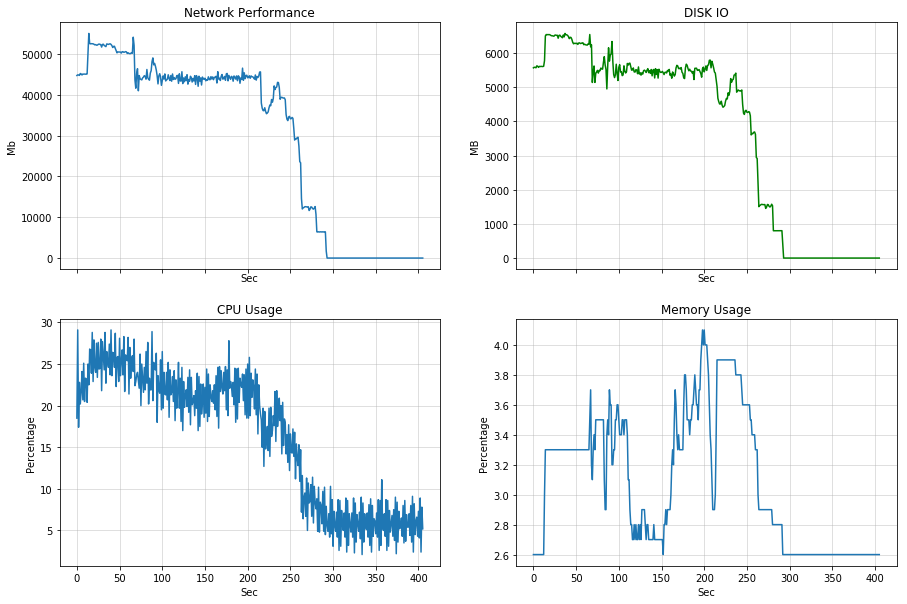

None

In [18]:
dtn.exec_command("python callmonitor_v2.py",graph_mode)

## Step A . stop the test nuttcp

In [19]:
exec_print("pkill nuttcp")

pkill: killing pid 10923 failed: Operation not permitted
pkill: killing pid 10924 failed: Operation not permitted
pkill: killing pid 10926 failed: Operation not permitted
pkill: killing pid 10927 failed: Operation not permitted
pkill: killing pid 10928 failed: Operation not permitted
pkill: killing pid 10929 failed: Operation not permitted
pkill: killing pid 10931 failed: Operation not permitted
pkill: killing pid 10932 failed: Operation not permitted
pkill: killing pid 10934 failed: Operation not permitted
pkill: killing pid 10935 failed: Operation not permitted
pkill: killing pid 10936 failed: Operation not permitted
pkill: killing pid 10937 failed: Operation not permitted
pkill: killing pid 10938 failed: Operation not permitted
pkill: killing pid 10939 failed: Operation not permitted
pkill: killing pid 10940 failed: Operation not permitted
pkill: killing pid 10941 failed: Operation not permitted


In [36]:
exec_print("sleep 3; ps -u "+ user +" ux |grep nuttcp")

sc17     24654  0.0  0.0   4512   700 ?        S    12:27   0:00 /bin/sh -c sleep 3; ps -u sc17 ux |grep nuttcp
sc17     24657  0.0  0.0  14228   936 ?        S    12:27   0:00 grep nuttcp
